## Installs

In [ ]:
!sudo apt-get update
!sudo apt-get install graphviz
!sudo apt install libgraphviz-dev -y
!pip install pygraphviz
!pip install catboost
!pip install daal4py
!pip install prompt_toolkit

In [5]:
from abc import ABC, abstractmethod
from collections import defaultdict
from time import time
import copy

import math
import random
import numpy as np
import pandas as pd
import re
import torch

from catboost import CatBoostClassifier
import daal4py as d4p
from prompt_toolkit import prompt
from prompt_toolkit.completion import WordCompleter

from policy import Policy

# Initialization

In [6]:
%%bigquery champion_stats
SELECT CAST(championId AS STRING) AS championId,
       * EXCEPT (championId,
                int64_field_0,
                patch,
                title,
                championName)
FROM avisia-training.leagueoflegend.champion_stats

Query is running:   0%|          |

Downloading:   0%|          |

In [7]:
%%bigquery champion_names
SELECT CAST(championId AS STRING) AS championId,
        championName
FROM avisia-training.leagueoflegend.champion_stats

Query is running:   0%|          |

Downloading:   0%|          |

In [8]:
champion_stats_indexed = (champion_stats.copy()).set_index('championId')
player_positions = ['teammates_0', 'enemies_0', 'enemies_1', 'teammates_1', 'teammates_2',
                    'enemies_2', 'enemies_3', 'teammates_3', 'teammates_4', 'enemies_4']
max_plays = 10
heroes_set = set([int(cid) for cid in champion_stats['championId']])
s_tier = ['Aatrox', 'Camille', 'Darius', 'Fiora', 'Jax', 'K\'Sante', 'Olaf', 'Poppy', 'Rengar', 'Riven',
            'Bel\'Veth', 'Briar', 'Ivern', 'Kindred',
            'Akshan', 'Kassadin', 'Neeko', 'Swain', 'Sylas', 'Syndra', 'Taliyah', 'Talon', 'Zoe',
            'Ezreal', 'Jinx', 'Vayne',
            'Bard', 'Blitzcrank', 'Rakan', 'Rell', 'Senna', 'Thresh']
pick_or_ban = np.array(['P','P','P','P','P',
                        'P','P','P','P','P'])
playing_team = np.array(['B','R','R','B','B',
                         'R','R','B','B','R'])

model = CatBoostClassifier()
model.load_model('catboost_model.cbm')

policy = Policy(165)
checkpoint = torch.load('policy.pth')
policy.load_state_dict(checkpoint)
policy.eval()

id_cid = {i+1: int(c.championId) for i, c in champion_names.iterrows()}
cid_id = {int(c.championId): i+1 for i, c in champion_names.iterrows()}
id_cid[0] = 0
cid_id[0] = 0

def get_heroe_id(heroe_name):
    return int(champion_names[champion_names['championName'] == heroe_name].championId.item())

def get_heroe_name(heroe_id):
    return champion_names[champion_names['championId'] == str(heroe_id)].championName.item()

s_tier_is_in = pd.Series([0]*len(champion_names), index=champion_names['championId'].astype('int') )
s_tier_is_in[[get_heroe_id(heroe) for heroe in s_tier]] = 1
p_champions = (1 + 4*s_tier_is_in)/len(champion_stats)
p_champions = (p_champions/p_champions.sum()).to_dict()
def probability_pick(states, heroe):
    return p_champions[heroe]


def model_win_rate(predecessors_batch):
    "Join match-up with stat informations"
    x = pd.DataFrame(predecessors_batch, columns=player_positions).astype(str)
    x[champion_stats.columns]=None   # Dummy columns so suffix are activated with doublons
    x = pd.concat([ x[list(champion_stats.columns)+[pos]].merge(
                        champion_stats_indexed,
                        left_on=pos,
                        right_index=True,
                        suffixes=('', '_' + pos),
                        copy=False
                         )
                    for i, pos in enumerate(player_positions)
                   ], axis=1, copy=False)
    x.drop(columns=champion_stats.columns, inplace=True) # Drop dummy columns

    "Prediction"
    probabilities = model.predict_proba(x)[:,1]

    return probabilities

# MCTS

In [9]:
class Node(object):
    """
    A representation of a single board state.
    MCTS works by constructing a tree of these Nodes.
    Could be e.g. a chess or checkers board state.
    """

    def __init__(self, predecessors=[], hash=None):
        """
        A node is defined by its predecessors which represent
        all the picks including the current board state.
        """
        if hash is None:
            self.predecessors = predecessors
        else :
            self.predecessors = self.__predecessors_from_hash__(hash)

    def find_children(self):
        "All possible successors of this board state"
        children_predecessors = []
        available_heroes = heroes_set - set(self.predecessors)
        for state in available_heroes:
            child_predecessors = self.predecessors.copy()
            child_predecessors.append(state)
            children_predecessors.append(child_predecessors)
        return children_predecessors

    def find_random_child(self, deja_vu=set({}), seed=None):
        "Random successor of this board state except deja_vu states"
        if seed is not None:
            np.random.default_rng(seed)
        picks = np.array(list(heroes_set - set(self.predecessors) - deja_vu))
        state = np.random.choice( picks, size=1, p=self.probability(picks) )[0]
        child_preds = self.predecessors.copy()
        child_preds.append(state)
        return child_preds

    def find_random_children(self, deja_vu=set({}), seed=None):
        "Random terminal state from this board state except deja_vu states"
        if seed is not None:
            np.random.default_rng(seed)
        picks = np.array(list(heroes_set - set(self.predecessors) - deja_vu))
        successors = list(np.random.choice( picks, size=max_plays-self.get_depth(), p=self.probability(picks) ))
        return self.predecessors.copy()+successors

    def is_terminal(self):
        "Returns True if the node is terminal"
        return self.get_depth()==max_plays

    def reward(self):
        " !!! For MCTS: replaced by a parrallelized function !!! "
        "Assumes `self` is terminal node. 1=win, 0=loss, .5=tie, etc"
        return model_win_rate([self.predecessors]).item()

    def probability(self):
        "Probability of picking this last state knowing the predecessors"
        if len(self.predecessors)==0:
            return 1
        return probability_pick(self.predecessors[:-1], self.predecessors[-1])

    def probability(self, successors):
        "Probability of picking the states s knowing the predecessors"
        probs = [probability_pick(self.predecessors, s) for s in successors]
        if sum(probs) != 1:
          probs = [p/sum(probs) for p in probs]
        return probs

    def path_probability(self):
        "Assumes `self` is terminal node. 1=win, 0=loss, .5=tie, etc"
        prob=1
        for (i, state) in enumerate(self.predecessors):
            prob *= probability_pick(self.predecessors[:i], state)
        return prob

    def hash_set(self):
        "sort heroes for each team so this hash is unique by match-up"
        if len(self.predecessors)==0:
            return -1
        nb_predecessors = len(self.predecessors)
        team_B = sorted(np.array(self.predecessors)[(playing_team == 'B')[:nb_predecessors]])
        team_R = sorted(np.array(self.predecessors)[(playing_team == 'R')[:nb_predecessors]])
        return int(''.join(map(self._str_3_char, team_B)) + ''.join(map(self._str_3_char, team_R)))

    def get_predecessors(self):
        return self.predecessors

    def get_depth(self):
        return len(self.predecessors)

    def __hash__(self):
        "Nodes must be hashable"
        if len(self.predecessors)==0:
            return -1 # special hash for the unique root node
        return int(''.join(map(self._str_3_char, self.predecessors)))

    def __eq__(node1, node2):
        "Nodes must be comparable"
        return node1.__hash__() == node2.__hash__()

    def __str__(self):
        "hash as a string"
        if len(self.predecessors)==0:
            return str(-1)
        return ''.join(map(self._str_3_char, self.predecessors))

    def __predecessors_from_hash__(self, hash):
        "hash as a string"
        predecessors = []
        if hash != -1:
            s=str(hash)
            s="0"*( (3-(len(s) % 3)) % 3) + s
            predecessors = [ int(s[i*3: (i+1)*3]) for i in range(len(s) // 3)]
        return predecessors

    def _str_3_char(self, n):
      "encode each heroe ( 0 < # < 1000) with 3 char to ensure unicity"
      s = str(n)
      if len(s) < 3:
          s = '0' * (3 - len(s)) + s
      return s


In [10]:
class MCTS:
    "Monte Carlo tree searcher. First rollout the tree then choose a move."

    def __init__(self, exploration_weight=1, randomisation_weight=0.1, uct_exploration_breadth=20):
        self.exploration_weight = exploration_weight
        self.randomisation_weight = randomisation_weight
        self.uct_exploration_breadth = uct_exploration_breadth

    def choose(self, node, max_top=1, min_visits=5):
        "Choose the best successor of node. (Choose a move in the game)"
        if node.is_terminal():
            raise RuntimeError(f"choose called on terminal node {node}")

        if node in children:
            if node.predecessors==[]:
                subtree = children
            else:
                subtree = children[children.index.astype(str).str.contains(re.compile("^" + node.__str__()))]
            mask = subtree.index.map(lambda n: n.get_depth()==node.get_depth()+1)
            filtered = pd.Series(subtree[mask].index)
            hashes = filtered.map(lambda n: n.hash_set())
            Q_c = Q_N['Q'][hashes]
            N_c = Q_N['N'][hashes]
            scores = (Q_c[N_c >= min_visits]/ N_c[N_c >= min_visits]).values
            max_top = min(max_top, len(scores))
            indices = np.argpartition(scores , -max_top)[-max_top:]
            indices = indices[np.argsort(scores[indices])]
            res = filtered[indices], scores[indices]
        else:
            res = [], []

        return res


    def parallel_rollouts(self, node, iterations, leaves=pd.Series([], dtype=object), rand=False, verbose=False, simulations=1):
        global children
        global Q_N
        start = time()
        if node.predecessors==[]:
            subtree = children
        else:
            subtree = children[children.index.astype(str).str.contains(re.compile("^" + node.__str__()))]
        if verbose:
            print('Subtree ', time()-start)
            start = time()

        "Select Paths"
        if len(leaves) == 0 :
            if rand:
                leaves = self._select_random(node, iterations, subtree)
            else:
                best = self._uct_select_all(node, iterations, subtree)
                leaves = best.map(lambda x: Node(x.find_random_child()))
            if len(leaves) == 0:  # Initialize with root if unexplored
                leaves = pd.Series([node])
                children[node] = 0
        if verbose:
            print("nb ", len(leaves))
            print('Select paths ', time()-start)
            start = time()

        "Expand"
        children = self._expand(node, leaves, children)
        if verbose:
            print('Expand ', time()-start)
            start = time()

        "Simulate"
        leaves_repeat = pd.concat([leaves] * simulations)
        # terminal_nodes = leaves.map(lambda n: n.find_random_children()).tolist()
        terminal_nodes = self._simulate_policy(leaves_repeat)
        rewards_repeat = model_win_rate(terminal_nodes)
        rewards = np.mean(np.split(rewards_repeat, simulations), axis=0)
        if verbose:
            print('Simulate ', time()-start)
            start = time()

        "Backpropagate"
        Q_N = self._backpropagate(leaves, rewards, Q_N, simulations)
        if verbose:
            print('Backpropagate ', time()-start)


    def _select_random(self, node, iterations, subtree):
        # Filter to get subtree and expandable nodes
        mask = (subtree < self.uct_exploration_breadth) & ~subtree.index.map(lambda n: n.is_terminal())
        filtered = pd.Series(subtree[mask].index)
        indices = np.random.choice(np.arange(len(filtered)), size=min(len(filtered), iterations), replace=False)
        filtered = filtered[indices]

        # Get random child
        seeds = pd.Series(range(len(filtered)), index=filtered, dtype='int')
        random_children = pd.Series( filtered.map(lambda x: Node(x.find_random_child(seed=seeds[x]))).unique() )
        return random_children

    def _uct_select_all(self, node, max_iterations, subtree):

        # Filter sub tree
        mask = (subtree < self.uct_exploration_breadth) & ~subtree.index.map(lambda n: n.is_terminal())
        filtered = pd.Series(subtree[mask].index)

        # Compute UCT
        max_iterations = min(max_iterations, len(filtered))
        hashes = filtered.map(lambda n: n.hash_set())
        N_parents = filtered.map(lambda n: Q_N['N'][Node(n.predecessors[:-1]).hash_set()])
        log_N_parent = np.log(N_parents).values
        Q_f = Q_N['Q'][hashes].values
        N_f = Q_N['N'][hashes].values
        ucts = Q_f/N_parents + self.exploration_weight * np.sqrt(log_N_parent/N_f)

        # Find argmax
        indices = np.argpartition(ucts, -max_iterations)[-max_iterations:]
        return filtered[indices]

    def _expand(self, node, leaves, children):
        if node.predecessors==[]:
            subtree = children
        else:
            subtree = children[children.index.astype(str).str.contains(re.compile("^" + node.__str__()))]

        # Update
        # do this before and take [node] in account
        new_leaves = leaves[~leaves.isin(subtree.index)]
        parents = new_leaves.map(lambda n: Node(n.predecessors[:-1]))
        parents_cnt = parents.groupby(parents, sort=False).count()
        subtree[parents_cnt.index] += parents_cnt #  !!! This will modify the copy of children as this is a view

        # Add new leaves to children
        children_new_leaves =  pd.Series([0]*len(new_leaves), index=new_leaves, dtype='int')
        new_children = pd.concat([children, children_new_leaves])
        return new_children

    def _simulate_policy(self, leaves):
        predecessors_cids = leaves.map(lambda n: n.predecessors).tolist()
        predecessors_ids = [ [cid_id[cid] for cid in predecessor_cids] for predecessor_cids in predecessors_cids]
        with torch.no_grad():
            _, successors_ids = policy(policy.preprocess(predecessors_ids))
        successors_cids = [ [id_cid[id] for id in successor_ids] for successor_ids in successors_ids.tolist()]
        return successors_cids

    def _backpropagate(self, leaves, rewards, Q_N, simulations):

        # Get all the predecessors with their associated reward
        rewards_indexed = pd.Series(rewards ,index=leaves)
        predecessor_reward = pd.Series(sum(list(
            leaves.map(
                lambda n: [(Node(n.predecessors[:i]), self._score(i, rewards_indexed[n])) \
                              for i in range(n.get_depth()+1)]
                )
            ), []))
        Q_predecessors = pd.Series(predecessor_reward.map(lambda x: x[1]).values,
                                   index=predecessor_reward.map(lambda x: x[0].hash_set()))

        # Sum by unique predecessor
        Q_predecessors_sum = Q_predecessors.groupby(Q_predecessors.index, sort=False).sum()
        Q_predecessors_count = Q_predecessors.groupby(Q_predecessors.index, sort=False).count()

        # update existing hashes in Q_N
        mask = Q_predecessors_sum.index.isin(Q_N.index)
        update_index = Q_predecessors_sum.index[mask]
        Q_N['N'][update_index] += Q_predecessors_count[update_index] * simulations
        Q_N['Q'][update_index] += Q_predecessors_sum[update_index] * simulations

        # concat new hashes
        new_index = Q_predecessors_sum.index[~mask]
        new_df =  pd.DataFrame({'Q': Q_predecessors_sum[new_index] * simulations,
                                'N': pd.Series([simulations]*len(new_index), index=new_index, dtype='float')})
        return pd.concat([Q_N, new_df])

    def _score(self, depth, reward):
        if playing_team[depth-1] != 'B':
            reward = 1-reward
        return reward

    def _uct_select(self, node, Q, N, children):
        "Select a child of node, balancing exploration & exploitation"

        log_N_vertex = math.log(N[node.hash_set()])
        def _uct(hash):
            "Upper confidence bound for trees"
            n = Node(hash=hash)
            hash_set = n.hash_set()
            N_n = N[hash_set]
            return Q[hash_set] / N_n + \
                   self.exploration_weight * math.sqrt(log_N_vertex / N_n)

        ucts = np.array(list(map(self._uct, children[node])))
        selected_index = np.argmax(ucts)
        selected_child = children[node][selected_index]
        # max(children[node], key=uct)

        return selected_child

In [11]:
mcts=MCTS()
mcts.randomisation_weight=0.1
node0 = Node()
Q_N = pd.DataFrame(columns=['Q', 'N'])
children = pd.Series(dtype='int64')

In [12]:
mcts.parallel_rollouts(Node([]), 500, rand=False, verbose=True)

Subtree  3.0994415283203125e-06
nb  1
Select paths  0.028026819229125977
Expand  0.00621485710144043
Simulate  3.7512474060058594
Backpropagate  0.03689932823181152


In [13]:
mcts.parallel_rollouts(node0, 500, rand=False, verbose=True) # set root
mcts.parallel_rollouts(node0, 500, leaves=pd.Series(node0.find_children()).map(lambda p: Node(p)), rand=True, verbose=True, simulations=25) # Simulate on childs
mcts.parallel_rollouts(node0, 500, rand=True, verbose=True) # Random exploration
mcts.parallel_rollouts(node0, 500, rand=True, verbose=True) # Random exploration
mcts.parallel_rollouts(node0, 500, rand=False, verbose=True) # ucts exploration
mcts.parallel_rollouts(node0, 500, rand=True, verbose=True) # Random exploration
mcts.parallel_rollouts(node0, 500, rand=False, verbose=True) # ucts exploration

Subtree  7.3909759521484375e-06
nb  1
Select paths  0.02894759178161621
Expand  0.005512237548828125
Simulate  0.2229011058807373
Backpropagate  0.0298464298248291
Subtree  4.5299530029296875e-06
nb  165
Select paths  0.0011630058288574219
Expand  0.018883466720581055
Simulate  4.191904067993164
Backpropagate  0.06556129455566406
Subtree  5.7220458984375e-06
nb  165
Select paths  0.2741405963897705
Expand  0.04335784912109375
Simulate  0.3539903163909912
Backpropagate  0.06815433502197266
Subtree  5.7220458984375e-06
nb  330
Select paths  0.4780852794647217
Expand  0.1509990692138672
Simulate  1.445909023284912
Backpropagate  0.24102210998535156
Subtree  5.245208740234375e-06
nb  500
Select paths  0.5257382392883301
Expand  0.1635913848876953
Simulate  0.8284859657287598
Backpropagate  0.3617286682128906
Subtree  6.198883056640625e-06
nb  500
Select paths  0.8073837757110596
Expand  0.33469700813293457
Simulate  1.075319528579712
Backpropagate  0.3026125431060791
Subtree  5.24520874023

## Plot

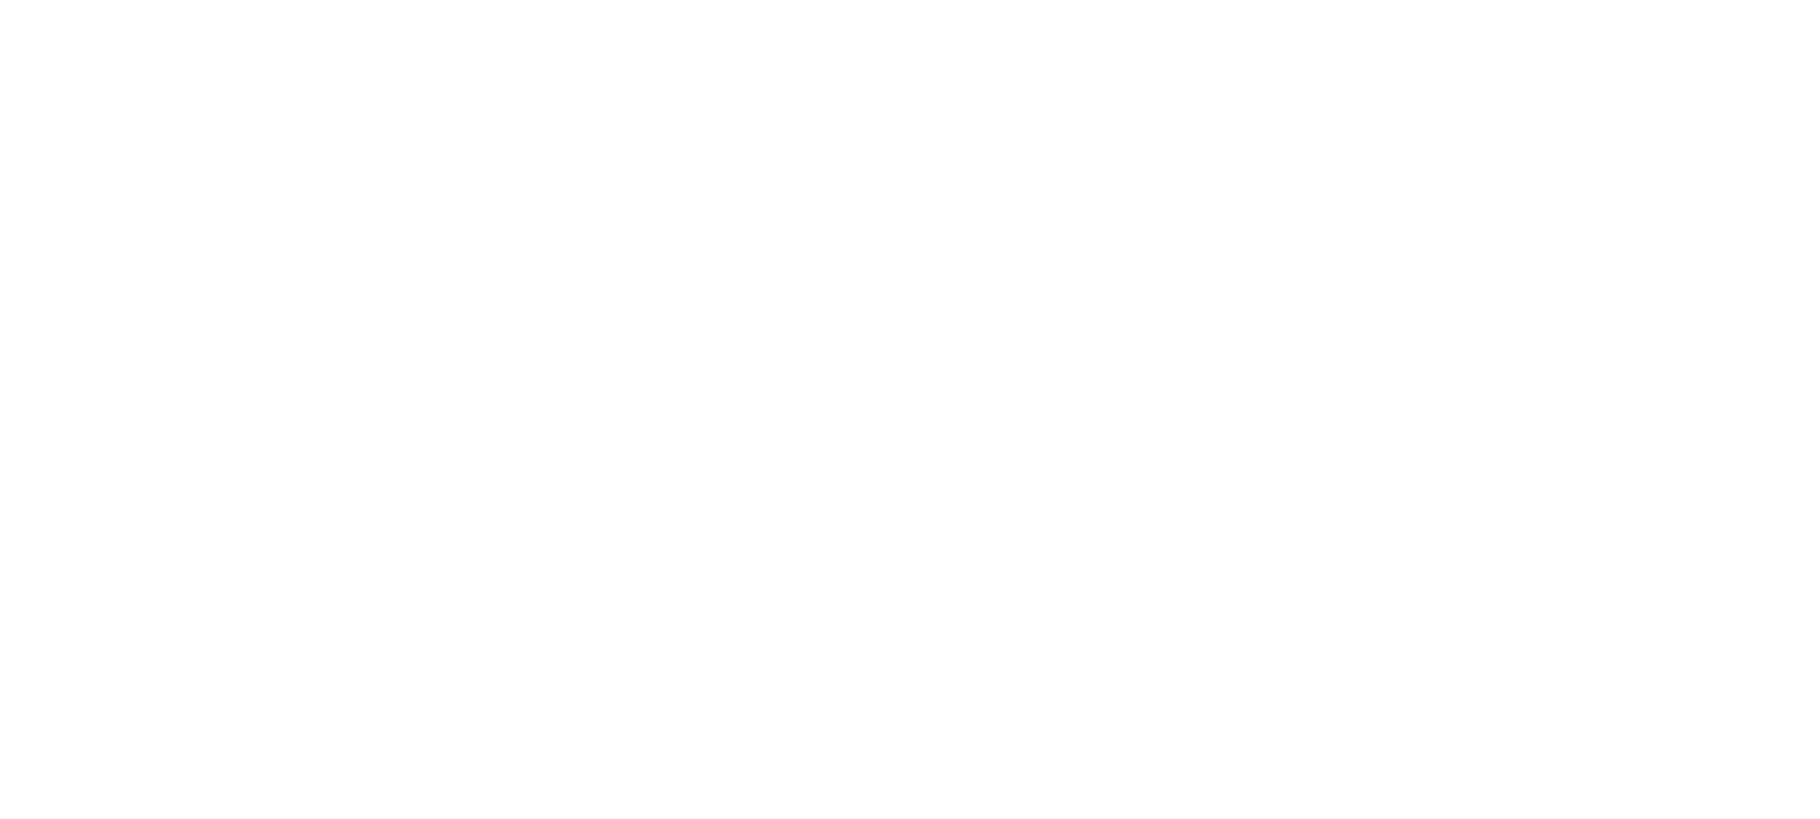

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

# Build the tree
G = nx.Graph()
stack = [(None, node0)]  # (parent, current_node)
visited = set()  # To keep track of visited nodes
max_depth=2
min_visits=45
while stack:
    parent, node = stack.pop()
    if node not in visited:
        visited.add(node)
        if parent is not None:
            G.add_edge(parent, node)
        if node in children:
            for child_preds in node.find_children():
                child = Node(child_preds)
                hash_set = child.hash_set()
                if hash_set in Q_N.index and child.get_depth()<=max_depth and \
                   child.predecessors[-1] < 1000 :
                    if Q_N['N'][hash_set] > min_visits:
                        stack.append((node, child))

# Graphics
#pos = nx.spring_layout(G)  # Define the layout of the tree
plt.figure(figsize=(18, 8))
pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='dot')
node_colors = [Q_N['N'][node.hash_set()] for node in G.nodes]

# Adjust vertical positions of nodes
label_pos = {k: (x, y - 0.0) for k, (x, y) in pos.items()}

# Draw the nodes and edges
nx.draw(G, pos, with_labels=False, node_color=node_colors, cmap=plt.cm.Pastel1, node_size=500)
labels = {node: f"{Q_N['Q'][node.hash_set()]/(1+Q_N['N'][node.hash_set()]):.2f}" for node in G.nodes}
labels2 = {node: get_heroe_name(node.predecessors[-1]) if node.predecessors else "Root" for node in G.nodes}
nx.draw_networkx_labels(G, label_pos, labels=labels, font_size=10, verticalalignment="bottom")
nx.draw_networkx_labels(G, label_pos, labels=labels2, font_size=10, verticalalignment="top")

# Show the plot
plt.show()

# Execution

In [ ]:
def explore_tree(node, iterations=1000):
    mcts.parallel_rollouts(node, 500, rand=False, verbose=False) # set root
    mcts.parallel_rollouts(node, 500, leaves=pd.Series(node.find_children()).map(lambda p: Node(p)),
                           rand=True, verbose=False, simulations=25) # Simulate on children for cold start
    for i in range(1):
        mcts.parallel_rollouts(node, 500, rand=True, verbose=False) # Random exploration
        mcts.parallel_rollouts(node, 500, rand=False, verbose=False) # ucts exploration
        mcts.parallel_rollouts(node, 500, rand=False, verbose=False) # ucts exploration

for i in range(11):
    print(' / '.join(champion_names.championName[15*i:15*(i+1)]))
print()

max_top=3
min_visits=100
current_node = node0
for turn in range(max_plays):
    print(f"Turn {turn + 1},", player_positions[turn])

    # Choose the best move using MCTS
    best_moves, scores = mcts.choose(current_node, max_top=max_top, min_visits=min_visits)
    if len(best_moves) < max_top:
        print("Unexplored board state, calculating")
        while len(best_moves) < max_top:
            explore_tree(current_node)
            best_moves, scores = mcts.choose(current_node, max_top=max_top, min_visits=min_visits)

    print("Best Heroes:")
    for best_move, score in zip(best_moves, scores):
         print(f"  {get_heroe_name(Node(hash=best_move).predecessors[-1])}, Win Rate: {score:.3f}")

    # Player enters the node ID
    heroe_name = input("Input: ")
    while not np.isin(heroe_name, champion_names['championName']).item():
        if heroe_name == "":
            print("Tree exploration")
            explore_tree(current_node)
            best_moves, scores = mcts.choose(current_node, max_top=max_top, min_visits=min_visits)
            for best_move, score in zip(best_moves, scores):
                print(f"  {get_heroe_name(Node(hash=best_move).predecessors[-1])}, Win Rate: {score:.3f}")
        heroe_name = input("Input: ")

    # heroes_completer = WordCompleter(list(map(str, heroes_set)))
    # node_id = prompt("Choose Heroe: ", completer=heroes_completer)

    # Update the current node with the player's input
    current_node = Node(current_node.predecessors + [get_heroe_id(heroe_name)])
    picks_B = np.array(current_node.predecessors)[playing_team[:len(current_node.predecessors)]=='B']
    picks_R = np.array(current_node.predecessors)[playing_team[:len(current_node.predecessors)]=='R']

    print(f"Current Board State, B: {' / '.join(map(get_heroe_name, picks_B))}")
    print(f"                     R: {' / '.join(map(get_heroe_name, picks_R))}")
    print("-------------------")

win_rate_allies = 1 - (Q_N['Q'][current_node.hash_set()]/Q_N['N'][current_node.hash_set()])
print(f"Predicted win rate for allies: {win_rate_allies : .3f}")

Shen / Bel'Veth / Gangplank / Mordekaiser / Rek'Sai / Rakan / Akali / Kha'Zix / Naafiri / Shaco / Talon / Zed / Graves / Amumu / Cho'Gath
Galio / Maokai / Diana / Gragas / Aatrox / Camille / Darius / Hecarim / Illaoi / Kled / Wukong / Nasus / Olaf / Renekton / Sett
Shyvana / Skarner / Trundle / Udyr / Urgot / Volibear / Warwick / Yorick / Braum / Tahm Kench / Blitzcrank / Jarvan IV / Malphite / Nunu & Willump / Ornn
Poppy / Rammus / Sejuani / Singed / Sion / Zac / Alistar / Leona / Nautilus / Evelynn / Katarina / Taric / Ekko / Fizz / Master Yi
Qiyana / Rengar / Viego / Yone / Briar / Fiora / Gwen / Irelia / Jax / Kayn / Lee Sin / Nilah / Pantheon / Riven / Tryndamere
Vi / Xin Zhao / Yasuo / Pyke / Dr. Mundo / Sylas / Yuumi / Rell / K'Sante / Annie / Aurelion Sol / Brand / Cassiopeia / Karthus / Lissandra
Syndra / Twisted Fate / Veigar / Vel'Koz / Vex / Viktor / Vladimir / Xerath / Ziggs / Milio / Aphelios / Caitlyn / Corki / Draven / Jinx
Kai'Sa / Kalista / Kindred / Lucian / Miss For

# Analysis

In [ ]:
import matplotlib.pyplot as plt
plt.plot([1,2,3,4,5], [0.162, 0.193, 0.194, 0.191, 0.37])
plt.plot([1,2,3,4,5], [0.018, 0.032, 0.035, 0.090, 0.59])
plt.show()

In [ ]:
%%bigquery match_data
SELECT
    CAST (teammates_0 AS STRING) AS teammates_0,
    CAST (enemies_0 AS STRING) AS enemies_0,
    CAST (enemies_1 AS STRING) AS enemies_1,
    CAST (teammates_1 AS STRING) AS teammates_1,
    CAST (teammates_2 AS STRING) AS teammates_2,
    CAST (enemies_2 AS STRING) AS enemies_2,
    CAST (enemies_3 AS STRING) AS enemies_3,
    CAST (teammates_3 AS STRING) AS teammates_3,
    CAST (teammates_4 AS STRING) AS teammates_4,
    CAST (enemies_4 AS STRING) AS enemies_4,
    win
FROM
    `avisia-training.leagueoflegend.matchesv5`

In [ ]:
samples=1000
print("Completely random:",
      model_win_rate( [list(np.random.choice(np.array(list(heroes_set)), size=10)) for i in range(samples)] ).mean())

rows = np.random.randint(0, len(match_data), size=samples)
m=match_data
allies_random=[list(np.random.choice(np.array( list(heroes_set - set(m.iloc[row].astype('int')))), size=5)) for row in rows]
a=allies_random

print("Real draft:",
      model_win_rate( [m.iloc[r, :10].astype('int').tolist() for r in rows] ).mean())

preds=[[a[i][0], m.iloc[r,1], m.iloc[r,2], a[i][1], a[i][2],
    m.iloc[r,5], m.iloc[r,6], a[i][3], a[i][4], m.iloc[r,9]] for i, r in enumerate(rows)]
print("Random allies, real ennemies draft", model_win_rate(preds).mean())